In [1]:
import sys
import time
import gym
from gym import spaces
sys.path.append('/home/rafaelpossas/Dev/projects/rl-baselines-zoo')
%cd "/home/rafaelpossas/Dev/projects/rl-baselines-zoo/"
import os
os.chdir('/home/rafaelpossas/Dev/projects/rl-baselines-zoo/')
from utils import ALGOS, create_test_env
import pybullet_envs
import numpy as np
from stable_baselines.common import set_global_seeds
from stable_baselines.common.vec_env import VecNormalize, VecFrameStack, SubprocVecEnv
from stable_baselines.common.vec_env import dummy_vec_env
from stable_baselines.bench import Monitor

from delfi.simulator.BaseSimulator import BaseSimulator
from sklearn.linear_model import LinearRegression
import delfi.distribution as dd


/home/rafaelpossas/Dev/projects/rl-baselines-zoo


In [2]:
# CarPole
#env = gym.make('CartPole-v1')
env_id = 'CartPole-v1'
dim = 2
env_params = ['length','masspole']
#env_params = ['masspole']
p = dd.Uniform(lower=[0.1, 0.1], upper=[2., 2.])

# True values for the observation
true_obs = [0.7, 1.3]

In [3]:
# Sets up the problem
class ARGS():
    def __init__(self, env): 
        self.env = env
        self.folder = '/home/rafaelpossas/Dev/projects/rl-baselines-zoo/trained_agents'
        self.algo = 'ppo2'
        self.n_envs = 1
        self.no_render = True
        self.deterministic = False
        self.norm_reward = False
        self.seed = 0
        self.reward_log = '/tmp/'

args = ARGS(env_id)  
algo = args.algo
folder = args.folder
model_path = "{}/{}/{}.pkl".format(folder, algo, "uniform_CartPole-v1")

# Sanity checks
#assert os.path.isdir(folder + '/' + algo), "The {}/{}/ folder was not found".format(folder, algo)
#assert os.path.isfile(model_path), "No model found for {} on {}, path: {}".format(algo, env_id, model_path)

if algo in ['dqn', 'ddpg']:
    args.n_envs = 1

set_global_seeds(args.seed)

#is_atari = 'NoFrameskip' in env_id

stats_path = "{}/{}/{}/".format(folder, algo, env_id)
if not os.path.isdir(stats_path):
    stats_path = None

log_dir = args.reward_log if args.reward_log != '' else None

if not 'Bullet' in env_id:
    env = create_test_env(env_id, n_envs=args.n_envs, is_atari=False,
                      stats_path=stats_path,
                      seed=args.seed, log_dir=log_dir, should_render=not args.no_render)
else:
    env = gym.make("HopperBulletEnv-v0")
    env.render(mode="human")



model = ALGOS[algo].load(model_path)
obs = env.reset()

# Force deterministic for DQN and DDPG
deterministic = args.deterministic or algo in ['dqn', 'ddpg']


Loading a model without an environment, this model cannot be trained until it has a valid environment.
INFO:tensorflow:Summary name model/pi_fc0/w:0 is illegal; using model/pi_fc0/w_0 instead.
INFO:tensorflow:Summary name model/pi_fc0/b:0 is illegal; using model/pi_fc0/b_0 instead.
INFO:tensorflow:Summary name model/vf_fc0/w:0 is illegal; using model/vf_fc0/w_0 instead.
INFO:tensorflow:Summary name model/vf_fc0/b:0 is illegal; using model/vf_fc0/b_0 instead.
INFO:tensorflow:Summary name model/pi_fc1/w:0 is illegal; using model/pi_fc1/w_0 instead.
INFO:tensorflow:Summary name model/pi_fc1/b:0 is illegal; using model/pi_fc1/b_0 instead.
INFO:tensorflow:Summary name model/vf_fc1/w:0 is illegal; using model/vf_fc1/w_0 instead.
INFO:tensorflow:Summary name model/vf_fc1/b:0 is illegal; using model/vf_fc1/b_0 instead.
INFO:tensorflow:Summary name model/vf/w:0 is illegal; using model/vf/w_0 instead.
INFO:tensorflow:Summary name model/vf/b:0 is illegal; using model/vf/b_0 instead.
INFO:tensorfl

In [4]:
class RLSim(BaseSimulator):
    def __init__(self, dim=None, policy=None, env=None, env_params=[], gamma=1., seed=None):
        """RL Simulator. Given an environment and a policy, simulates data
        
        Parameters
        ----------
        dim : int
            Number of dimensions of parameters
        env : env
            Gym environment
        env_params : list
            env parameters to change
        seed : int or None
            If set, randomness is seeded
        """
        super().__init__(dim_param=dim, seed=seed)
        self.env = env
        self.policy = policy
        self.env_params = env_params
        self.gamma = gamma # Parameter for discounted reward
        #self.a = self.env.action_space.sample()     
        
    
    @copy_ancestor_docstring
    def gen_single(self, param):                
        # Update parameters of the simulator
        if hasattr(self.env, 'venv'):
            for i in range(len(self.env_params)):
                setattr(self.env.venv.get_attr('env')[0].env,
                        self.env_params[i], 
                        param[i])       
                   
        else:    
            for i in range(len(self.env_params)):
                setattr(self.env.get_attr('env')[0].env,
                        self.env_params[i], 
                        param[i])
                
        # Do a rollout 
        nsteps = 200
        s = self.env.reset()
        running_reward = 0.
        running_discounted = 0.
        deterministic = False
        ep_history = []
        for j in range(nsteps):
            # Pick an action given the policy
            a, _ = self.policy.predict(s, deterministic=deterministic)
            
            # Random Agent
            # action = [env.action_space.sample()]
            # Clip Action to avoid out of bound errors
            if isinstance(self.env.action_space, gym.spaces.Box):
                a = np.clip(a, self.env.action_space.low, self.env.action_space.high)
            
            #a = self.env.action_space.sample()
            #a = np.array([0.01, 0.01, 0.01, 0.01])
            #a = self.a
            
            s1, r, d, _ = self.env.step(a)
            
            s_shape = s.shape[1] 
            
            tmp = list(s.reshape(s_shape))
           
            if type(a) is np.ndarray:
                # Necessary for some simulators
                if type(a[0]) is np.int64:
                    a = a.tolist()
                    tmp.extend(a)
                else: 
                    at = a[0]
                    at = at.tolist()
                    tmp.extend(at)
            else:
                tmp.append(a)
            tmp.append(r)
            
            tmp.extend(list(s1.reshape((s_shape))))
            ep_history.append(tmp)
            s = s1
            
            running_reward += r
            running_discounted = running_discounted + self.gamma * r
            if d == True:
                s = env.reset()
                """
                #Sets the parameters again after each reset
                if self.env is type(VecNormalize):
                    for i in range(len(self.env_params)):
                        setattr(self.env.get_attr('env')[0].env,
                                self.env_params[i], 
                                param[i])
        
                else:
                    for i in range(len(self.env_params)):
                        setattr(self.env.venv.get_attr('env')[0].env,
                                self.env_params[i], 
                                param[i])
                """
        ep_history = np.array(ep_history)
        N = ep_history.shape[0]
        if True:
            # Cross correlation between difference of states and actions
            sdim = env.observation_space.shape[0]
            adim = np.size(env.action_space.sample())
            sample = np.zeros((sdim,adim))
            tmp = ep_history[:,sdim+adim+1:] - ep_history[:,0:sdim] # difference between states (s1-s)
            tmp2 = ep_history[:,sdim:sdim+adim] #actions
            
            for i in range(sdim):
                for j in range(adim):
                    sample[i, j] = np.dot(tmp[:,i], tmp2[:,j])/(N-1)    
            # Add mean of absolut states changes and std to the summary statistics
            sample = sample.reshape(-1)
            sample = np.append(sample, np.mean(np.abs(tmp), axis=0))
            sample = np.append(sample, np.std(tmp.tolist(), axis=0))
        
        #ind = np.isnan(sample)
        #sample[ind] = 0.
        return {'data': sample.reshape(-1)}    

In [5]:
# Updates and plots
import matplotlib.pyplot as plt

# Update env parameters
def update_env(env, env_param, param):
    # Update parameters of the simulator
    if hasattr(env,'venv'):
        setattr(env.venv.get_attr('env')[0].env,
                env_param, 
                param)
    # Regular gym environment
    elif hasattr(env,'env'):
        
        setattr(env.env,
                env_param, 
                param)
    else:
        setattr(env.get_attr('env')[0].env,
                env_param, 
                param)
    return

# Update env parameters in multi environments
def update_nenv(env, env_param, param, env_i):
    # Update parameters of the simulator
    if hasattr(env,'venv'):
        setattr(env.venv.get_attr('env')[env_i].env,
                env_param, 
                param) 
    else:
        setattr(env.get_attr('env')[env_i].env,
                env_param, 
                param)
        print(getattr(env.get_attr('env')[env_i].env, env_param))
    return


# Update env parameters
def getparam(env, env_param):

    # Update parameters of the simulator
    if hasattr(env,'venv'):
        param = getattr(env.venv.get_attr('env')[0].env,
                env_param) 
    else:
        param = getattr(env.get_attr('env')[0].env,
                env_param)
    return param

# Do a rollout 
def rollout(policy, env, gamma=1., nsteps=200):    
    obs = env.reset()
    running_reward = 0.
    running_discounted = 0.
    deterministic = False
    for j in range(nsteps):
        # Pick an action given the policy
        a, _ = policy.predict(obs, deterministic=deterministic)
        # Clip Action to avoid out of bound errors
        if isinstance(env.action_space, gym.spaces.Box):
            a = np.clip(a, env.action_space.low, env.action_space.high)
        obs, r, d, _ = env.step(a)
        running_reward += r
        running_discounted = running_discounted + gamma * r
        if d == True:
            break
    return running_reward, running_discounted

# Plots the robostness of a policy
def plot_robustness(policy, env, env_params, env_param_prior, nsteps = 100, ntests = 5):
    results_dict = {}
    for i in range(len(env_params)):
        # Gets the initial value
        param_init = getparam(env, env_params[i])
        plt.figure(i)
        if isinstance(p, dd.Gaussian):
            #Get limits from a Gaussian prior
            minlim = p.mean[i] - p.std[i]
            maxlim = p.mean[i] + p.std[i]
        else:
            #Get limits from a Uniform prior
            minlim = p.lower[i] - 0.1*p.lower[i]
            maxlim = p.upper[i] + 0.1*p.upper[i]
            
  
        x_plot = np.arange(minlim, maxlim, 0.05).reshape(-1)
        y_plot = np.zeros((x_plot.size, ntests))
        for k in range(ntests):
            for j in range(x_plot.size):
                update_env(env, env_params[i], x_plot[j])
                y_plot[j,k],_ = rollout(policy, env)
            update_env(env, env_params[i], param_init)   
            
        mean_y = np.mean(y_plot, 1)
        std_y = np.std(y_plot, 1)
        plt.plot(x_plot, mean_y, '-b', label=r'Accumulated rewards mean')
        plt.fill_between(x_plot, mean_y-std_y, mean_y+std_y, label=r'Accumulated rewards std', alpha=0.2)
        plt.axvline(param_init, c='r', label=r'Real value of '+ env_params[i])
        plt.legend(fontsize=10)
        plt.axis('on')
        plt.xlabel(env_params[i])
        # Resets to the original value
        update_env(env, env_params[i], param_init)
        results_dict[env_params[i]] = {}
        results_dict[env_params[i]]["x_plot"] = x_plot
        results_dict[env_params[i]]["y_plot"] = y_plot
        
    return results_dict

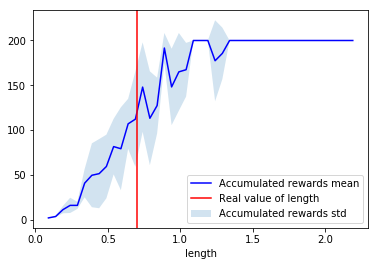

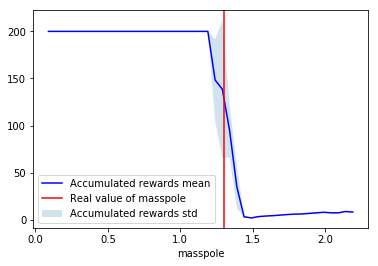

In [6]:
# Training on 100 environments for 2000000 iterations randomised by the prior 
# Set the true parameters
env.get_attr('env')[0].env.masspole = true_obs[1]
env.get_attr('env')[0].env.length = true_obs[0]
results_dic = plot_robustness(model, env, env_params, p)

In [7]:
import pickle

In [17]:
results_dic['length']["y_plot"][0:5]

array([[12., 12., 12., 12., 12.],
       [14., 12., 14., 14., 14.],
       [24., 14., 21., 21., 26.],
       [30., 16., 37., 31., 16.],
       [27., 25., 21., 33., 24.]])

In [18]:
f = open("uniform_cartpole_rewards.pkl", 'wb')
pickle.dump(results_dic, f)
f.close()